In [1]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import pickle
import pandas as pd
import os

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    precision_score, recall_score
)


def evaluate_model(y_true, y_pred, y_score=None):
    """
    Evaluate model performance with metrics and visualizations.
    
    y_true: true labels
    y_pred: predicted labels
    y_score: predicted probabilities (required for ROC curves)
    """
    
    # ======== PRINT METRICS ========
    print("\nPerformance on test data:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, average="weighted"))
    print('Recall:', recall_score(y_true, y_pred, average="weighted"))
    
    # ======== CONFUSION MATRIX HEATMAP ========
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
    
    


In [7]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def train_stacking(model1, model2, model3, model4, X_train, X_test, y_train, y_test):
    # Base models
    base_estimators = [
        ('dt', model1),
        ('rf', model2),
        ('lr', model3),
        ('svc', model4)
    ]
    
    # Stacking ensemble
    stack = StackingClassifier(
        estimators=base_estimators,
        final_estimator=LogisticRegression(max_iter=1000),
        stack_method='predict_proba'
    )
    
    # Parameter grid for tuning
    param_grid = {
        "final_estimator__C": [0.1, 1, 10],
        "final_estimator__solver": ["liblinear", "lbfgs"]
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(stack, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    print("\nStacking Classifier:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Validation Score:", grid_search.best_score_)
    
    return evaluate_model(y_test, y_pred)


In [3]:
from sklearn.ensemble import VotingClassifier

def train_ensemble(model1, model2, model3, model4, X_train, X_test, y_train, y_test):
    ensemble = VotingClassifier(
        estimators=[
        ('dt', model1),
        ('rf', model2),
        ('lr', model3),
        ('svc', model4)
    ]
    )
    param_grid = {
        "voting" : ["soft", "hard"],
        "weights": [[1, 1, 1, 1], [1, 2, 2, 1]]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(ensemble, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("\nLogistic Regression:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Validation Score:", grid_search.best_score_)

    return evaluate_model(y_test, y_pred)
    

In [4]:
X_test = pd.read_csv('./tfidf/test.csv')
y_test = pd.read_csv('./split/test.csv')
y_test = y_test['label']
with open("label_encoder.pkl", "rb") as f:
    y_encoded = pickle.load(f)

dir = './models'
os.makedirs(dir, exist_ok=True)

In [5]:
with open("./models/model1.pkl", "rb") as f:
    model1 = pickle.load(f)
with open("./models/model2.pkl", "rb") as f:
    model2 = pickle.load(f)
with open("./models/model3.pkl", "rb") as f:
    model3 = pickle.load(f)
with open("./models/model4.pkl", "rb") as f:
    model4 = pickle.load(f)


Logistic Regression:
Best Parameters: {'voting': 'soft', 'weights': [1, 1, 1, 1]}
Best Validation Score: 0.8546121593291405

Performance on test data:
Confusion Matrix:
[[495  22]
 [138 405]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.78      0.96      0.86       517
        real       0.95      0.75      0.84       543

    accuracy                           0.85      1060
   macro avg       0.87      0.85      0.85      1060
weighted avg       0.87      0.85      0.85      1060

Accuracy:  0.8490566037735849
Precision: 0.8672759610658618
Recall: 0.8490566037735849


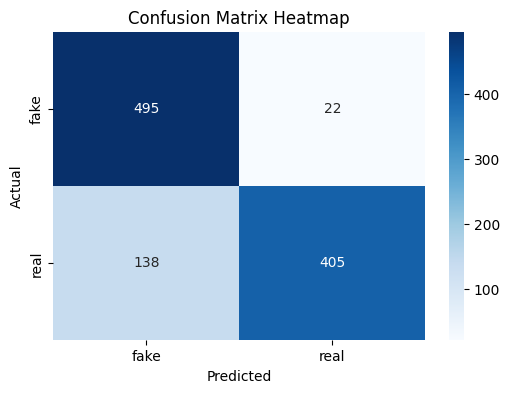

In [6]:
X_train = pd.read_csv("./split/train_df_encoded.csv")
y_train = pd.read_csv("./split/train.csv")
y_train = y_train['label']
y_train_encoded = y_encoded.transform(y_train)
train_ensemble(model1, model2, model3, model4, X_train, X_test, y_train, y_test)


Stacking Classifier:
Best Parameters: {'final_estimator__C': 0.1, 'final_estimator__solver': 'lbfgs'}
Best Validation Score: 0.8848008385744235

Performance on test data:
Confusion Matrix:
[[472  45]
 [ 87 456]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.84      0.91      0.88       517
        real       0.91      0.84      0.87       543

    accuracy                           0.88      1060
   macro avg       0.88      0.88      0.88      1060
weighted avg       0.88      0.88      0.88      1060

Accuracy:  0.8754716981132076
Precision: 0.8780794505093166
Recall: 0.8754716981132076


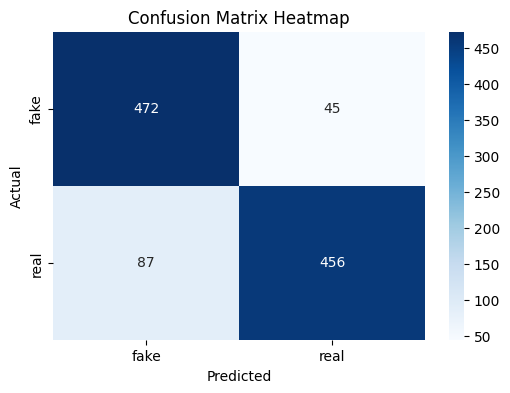

In [8]:
X_train = pd.read_csv("./split/train_df_encoded.csv")
y_train = pd.read_csv("./split/train.csv")
y_train = y_train['label']
y_train_encoded = y_encoded.transform(y_train)
train_stacking(model1, model2, model3, model4, X_train, X_test, y_train, y_test)